# Comparative Analysis of Load Balancing Algorithms
This notebook performs a comparative analysis of different load balacing strategies using JSON metrics files.

## Section 1: Import Required Libraries
Import the necessary libraries for data loading, manipulation, and visualization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set Seaborn style
sns.set_theme(style="whitegrid")

## Section 2: Load Benchmark Metrics JSON Files
Use `os.listdir()` to find all JSON files in the `benchmarks` folder and load each into a pandas DataFrame, capturing the strategy name.

In [2]:
# Path to benchmarks folder
benchmarks_dir = "benchmarks"

# Load JSON files into DataFrames
data_frames = []
import json
for file in os.listdir(benchmarks_dir):
    if file.endswith('.json'):
        strategy = file.replace('metrics_', '').replace('.json', '')
        json_path = os.path.join(benchmarks_dir, file)
        with open(json_path, 'r') as f:
            raw = json.load(f)
        # Normalize raw JSON into DataFrame
        df = pd.json_normalize(raw)
        df['strategy'] = strategy
        data_frames.append(df)

# Display count of loaded DataFrames
print(f"Loaded {len(data_frames)} benchmark files.")

Loaded 7 benchmark files.


## Section 3: Combine and Normalize Data
Concatenate individual DataFrames into a single DataFrame and flatten nested JSON metrics into columns. Normalize latency to milliseconds.

In [3]:
# Combine into single DataFrame
combined_df = pd.concat(data_frames, ignore_index=True)
# Replace dots in column names
combined_df.columns = combined_df.columns.str.replace('.', '_', regex=False)

# Convert time-based metrics from nanoseconds to milliseconds
ns_cols = ['latencies_total','latencies_mean','latencies_50th','latencies_95th','latencies_99th','latencies_max','duration','wait']
for col in ns_cols:
    if col in combined_df.columns:
        combined_df[col + '_ms'] = combined_df[col] / 1e6

# Create a unified latency_ms (mean latency in ms)
if 'latencies_mean_ms' in combined_df.columns:
    combined_df['latency_ms'] = combined_df['latencies_mean_ms']

combined_df

,earliest,latest,end,duration,wait,requests,rate,throughput,success,errors,...,strategy,latencies_total_ms,latencies_mean_ms,latencies_50th_ms,latencies_95th_ms,latencies_99th_ms,latencies_max_ms,duration_ms,wait_ms,latency_ms
0,2025-09-03T23:29:07.74852125-07:00,2025-09-03T23:31:07.746334042-07:00,2025-09-03T23:31:08.04888225-07:00,119997812792,302548208,60000,500.009114,498.751621,1,[],...,leastlatency,1.202225e+07,200.370863,199.183641,297.490449,328.343291,636.322958,119997.812792,302.548208,200.370863
1,2025-09-03T23:35:25.658005417-07:00,2025-09-03T23:37:25.655730334-07:00,2025-09-03T23:37:26.101925792-07:00,119997724917,446195458,60000,500.009480,498.157149,1,[],...,prequal,8.253135e+06,137.552253,133.169048,203.814299,302.989525,504.424000,119997.724917,446.195458,137.552253
2,2025-09-03T23:22:49.561000167-07:00,2025-09-03T23:24:49.558897042-07:00,2025-09-03T23:24:49.723010125-07:00,119997896875,164113083,60000,500.008763,499.325869,1,[],...,random,7.261852e+06,121.030874,124.085292,179.173642,201.759759,264.835084,119997.896875,164.113083,121.030874
3,2025-09-03T23:24:55.545872875-07:00,2025-09-03T23:26:55.5437395-07:00,2025-09-03T23:26:55.719610041-07:00,119997866625,175870541,60000,500.008889,499.277142,1,[],...,roundrobin,7.432088e+06,123.868125,113.769592,199.954138,226.669427,288.390958,119997.866625,175.870541,123.868125
4,2025-09-03T23:27:01.545851208-07:00,2025-09-03T23:29:01.543677958-07:00,2025-09-03T23:29:01.983108375-07:00,119997826750,439430417,60000,500.009055,498.184710,1,[],...,leastrif,1.681811e+07,280.301834,261.223451,505.105283,591.952932,710.083334,119997.826750,439.430417,280.301834
5,2025-09-03T23:31:13.795940042-07:00,2025-09-03T23:33:13.793800875-07:00,2025-09-03T23:33:13.935978209-07:00,119997860833,142177334,60000,500.008913,499.417188,1,[],...,power2_leastrif,5.559956e+06,92.665941,79.419424,167.915440,192.318847,248.698042,119997.860833,142.177334,92.665941
6,2025-09-03T23:33:19.743178333-07:00,2025-09-03T23:35:19.741273416-07:00,2025-09-03T23:35:19.846036625-07:00,119998095083,104763209,60000,500.007937,499.571791,1,[],...,power2_leastlatency,4.438924e+06,73.982058,72.552362,103.006772,120.900383,293.406583,119998.095083,104.763209,73.982058


## Section 4: Compute Summary Statistics
Group the combined data by strategy and compute mean, median, and standard deviation for each key performance metric.

In [4]:
# Create summary DataFrame (one row per strategy)
summary_df = combined_df.set_index('strategy')[[  
    'latency_ms',      # mean latency in ms
    'latencies_50th_ms',  # median latency
    'latencies_95th_ms',  # 95th percentile
    'latencies_99th_ms',  # 99th percentile
    'latencies_max_ms',   # max latency
    'throughput',      # requests per second
    'bytes_in_mean'    # mean bytes in
]].reset_index()
summary_df

,strategy,latency_ms,latencies_50th_ms,latencies_95th_ms,latencies_99th_ms,latencies_max_ms,throughput,bytes_in_mean
0,leastlatency,200.370863,199.183641,297.490449,328.343291,636.322958,498.751621,81.430367
1,prequal,137.552253,133.169048,203.814299,302.989525,504.424000,498.157149,80.791700
2,random,121.030874,124.085292,179.173642,201.759759,264.835084,499.325869,80.472867
3,roundrobin,123.868125,113.769592,199.954138,226.669427,288.390958,499.277142,80.412650
4,leastrif,280.301834,261.223451,505.105283,591.952932,710.083334,498.184710,81.639267
5,power2_leastrif,92.665941,79.419424,167.915440,192.318847,248.698042,499.417188,79.952500
6,power2_leastlatency,73.982058,72.552362,103.006772,120.900383,293.406583,499.571791,79.725700


## Section 5: Plot Latency Comparison
Visualize average latency across all strategies with error bars for standard deviation.

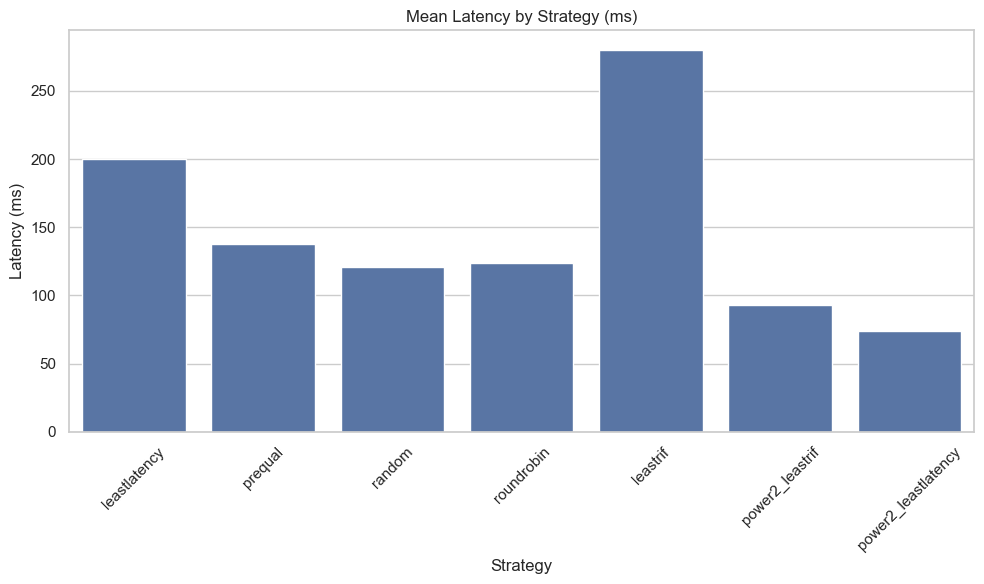

In [5]:
plt.figure(figsize=(10,6))
sns.barplot(
    x='strategy', y='latency_ms', data=summary_df)
plt.title('Mean Latency by Strategy (ms)')
plt.xlabel('Strategy')
plt.ylabel('Latency (ms)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

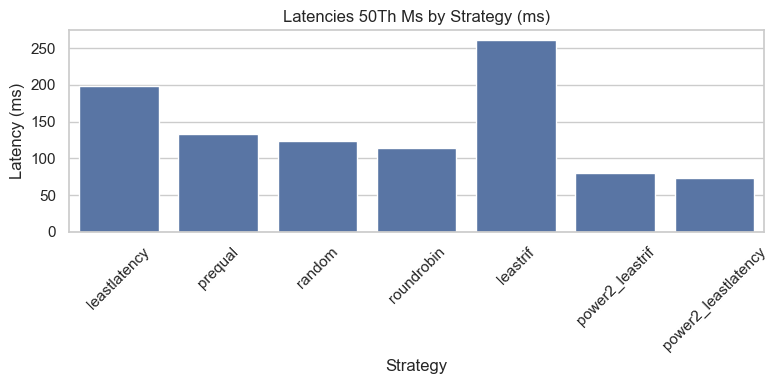

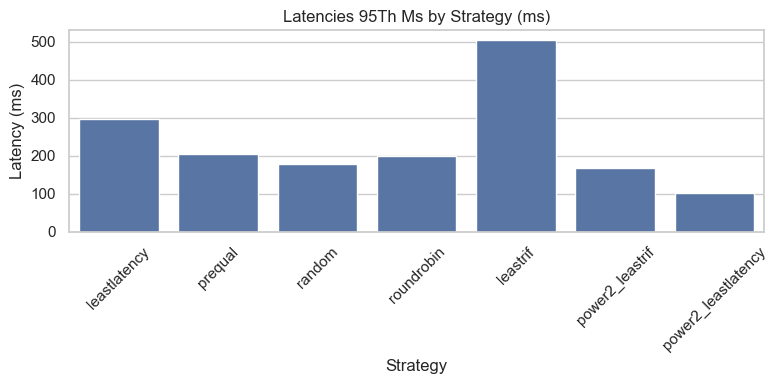

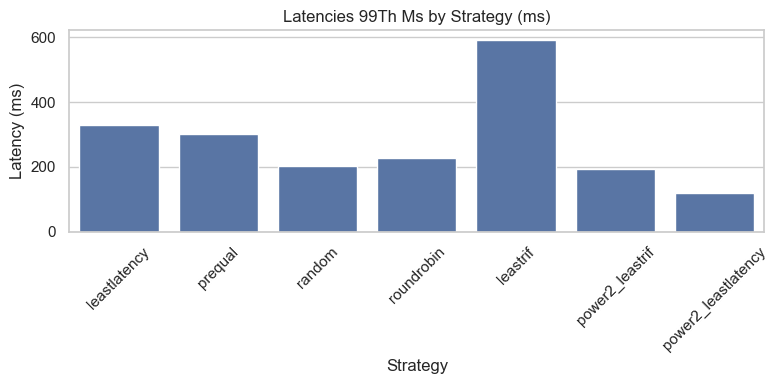

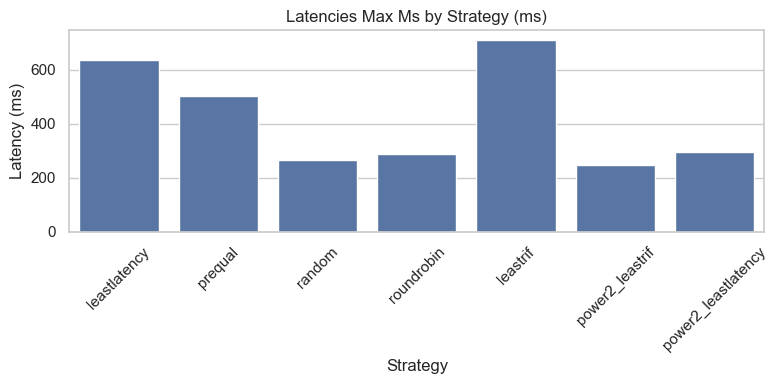

In [6]:
# Plot additional latency metrics
metrics = ['latencies_50th_ms','latencies_95th_ms','latencies_99th_ms','latencies_max_ms']
for metric in metrics:
    plt.figure(figsize=(8,4))
    sns.barplot(x='strategy', y=metric, data=summary_df)
    plt.title(f"{metric.replace('_',' ').title()} by Strategy (ms)")
    plt.xlabel('Strategy')
    plt.ylabel('Latency (ms)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()